# SCHEMAS

In [1]:
from pydantic import BaseModel, Field
from typing import Any, List, Literal, NotRequired, Optional
from typing_extensions import TypedDict
from typing_extensions import Annotated, Sequence
import operator
from pdf_hunter.agents.image_analysis.schemas import PrioritizedURL, ImageAnalysisReport
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [2]:
class AnalystFindings(BaseModel):
    """The synthesized analysis of the investigation log."""
    final_url: str = Field(..., description="The final destination URL reached by the Investigator.")
    verdict: Literal["Benign", "Suspicious", "Malicious", "Inaccessible"]
    confidence: float
    summary: str = Field(..., description="A concise, executive summary of the investigation, explaining the key findings and the reasoning behind the verdict.")
    detected_threats: List[str] = Field(default_factory=list)
    domain_whois_record: Optional[str] = Field(None, description="The summary of the WHOIS record for the final root domain, extracted from the investigation log.")
    screenshot_paths: List[str] = Field(default_factory=list, description="A list of all screenshot file paths mentioned in the investigation log.")
    mission_status: Literal["completed", "failed"] = Field(..., description="The status of the analysis mission for this URL.")

# The final, assembled forensic report.
class URLAnalysisResult(BaseModel):
    """The final, assembled forensic report, created programmatically by our code."""
    initial_url: PrioritizedURL
    full_investigation_log: List[dict]
    analyst_findings: AnalystFindings

# The state for our final two-stage pipeline graph.
class URLInvestigationState(TypedDict):
    # Inputs
    output_directory: str
    session_id: str        # Added for session management
    visual_analysis_report: NotRequired[ImageAnalysisReport]
    high_priority_urls: List[PrioritizedURL]
    errors: Annotated[List[str], operator.add]

    link_analysis_final_reports: Annotated[List[URLAnalysisResult], operator.add]

class URLInvestigationInputState(TypedDict):
    output_directory: str
    session_id: str        # Added for session management
    visual_analysis_report: NotRequired[ImageAnalysisReport]


class URLInvestigationOutputState(TypedDict):
    output_directory: str  # Added to pass session directory to other agents
    session_id: str        # Added to pass session ID to other agents
    link_analysis_final_reports: Annotated[List[URLAnalysisResult], operator.add]
    errors: Annotated[List[str], operator.add]


class URLInvestigatorState(TypedDict):
    """
    State for the URL Investigator sub-agent.
    """
    # Inputs
    url_task: PrioritizedURL
    output_directory: str
    session_id: str        # Added for session management

    # Intermediate
    investigation_logs: Annotated[Sequence[BaseMessage], operator.add]

    # Outputs
    errors: Annotated[List[str], operator.add]
    link_analysis_final_report: URLAnalysisResult


class URLInvestigatorOutputState(TypedDict):
    link_analysis_final_report: URLAnalysisResult
    errors: Annotated[List[str], operator.add]

# NODES

In [5]:
import os
import json
import asyncio
from datetime import datetime
from loguru import logger
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from typing import Literal
from pdf_hunter.agents.image_analysis.schemas import URLMissionStatus
from pdf_hunter.agents.url_investigation.tools import domain_whois
from pdf_hunter.shared.utils.serializer import dump_state_to_file
from langgraph.types import Send
from langgraph.graph import END
from pdf_hunter.config import THINKING_TOOL_ENABLED
from pdf_hunter.config.execution_config import LLM_TIMEOUT_TEXT


from pdf_hunter.config import url_investigation_investigator_llm, url_investigation_analyst_llm
from pdf_hunter.agents.url_investigation.prompts import URL_INVESTIGATION_INVESTIGATOR_SYSTEM_PROMPT, URL_INVESTIGATION_ANALYST_SYSTEM_PROMPT, URL_INVESTIGATION_ANALYST_USER_PROMPT

In [6]:
# Helper function to load MCP tools asynchronously
async def load_mcp_tools_async(session):
    """
    Load MCP tools in a non-blocking way by moving the import to a separate thread.
    
    Args:
        session: The MCP session to use
        
    Returns:
        The loaded MCP tools
    """
    def _load_tools():
        from langchain_mcp_adapters.tools import load_mcp_tools
        return load_mcp_tools
    
    load_mcp_tools_fn = await asyncio.to_thread(_load_tools)
    return await load_mcp_tools_fn(session)

In [7]:
from utils import show_prompt

In [8]:
show_prompt(URL_INVESTIGATION_INVESTIGATOR_SYSTEM_PROMPT, "URL Investigation System Prompt")

╭──────────────────────────────────────── URL Investigation System Prompt ────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  **You are the Web Forensics Investigator (WFI).** Your mission is to conduct a complete, live, interactive     │
│  forensic investigation of a URL that has been extracted from a PDF document during malware analysis. You are   │
│  a skilled multi-modal and persistent detective, able to analyze both text and visual layouts, assuming the     │
│  adversary is using multi-step evasion tactics. Your entire process is governed by a **Core Investigation       │
│  Loop**.                                                                                                        │
│                                                                                                                 │
│  **CRITICAL CONTEXT:** The URL you are investigating was extracted from a PDF document (not found on a          │
│  website). The PDF may have contained deceptive elements like fake verification prompts, misleading QR codes,   │
│  or social engineering tactics to trick users into visiting the URL. Your job is to investigate where this      │
│  extracted URL leads and determine if it's part of a larger attack chain.                                       │
│                                                                                                                 │
│  ---                                                                                                            │
│  ### **Your Core Investigation Loop (Observe -> Orient -> Decide -> Act)**                                      │
│                                                                                                                 │
│  You will repeat this loop until the mission is complete.                                                       │
│                                                                                                                 │
│  **1. OBSERVE: What is the current state?**                                                                     │
│     *   On your very first turn, your observation is the initial briefing.                                      │
│     *   On all subsequent turns, you MUST perform a full observation of the new page state:                     │
│         1. Take a **tactical screenshot** (`full_page=False`) to get immediate visual context (base64).         │
│         2. **CRITICAL**: If you see any cookie consent dialog, privacy notice, or overlay in the screenshot,    │
│  you MUST immediately use `browser_click` to dismiss it before proceeding. Look for buttons containing          │
│  "Accept", "Agree", "OK", "Allow", or similar text.                                                             │
│         3. Take a **forensic screenshot** (`full_page=True`) to save the complete evidence to a file. This is   │
│  critical and non-negotiable. You will only get a file path back.                                               │
│         4. Use `browser_evaluate` to get the page's text (use arrow function: `() =>                            │
│  document.body.innerText`).                                                                                     │
│         5. Use `browser_network_requests` to check for any new activity.                                        │
│                                                                                                                 │
│  **2. ORIENT: What does the evidence mean?**                                                                    │
│     *   Analyze the evidence from your OBSERVE step in the context of your initial briefing (the "Reason        │
│  Flagged").                                           

In [38]:
async def investigate_url(state: URLInvestigatorState):
    """Analyze current state and decide on tool usage with MCP integration.

    This node uses an LLM to determine the next steps in the investigation,
    including whether to call a tool or proceed with analysis. It integrates
    with MCP for dynamic tool execution.
    """
    
    try:
        url_task = state.get("url_task")
        session_output_dir = state.get("output_directory")
        
        # Validate required inputs
        if not url_task:
            raise ValueError("url_task is required")
        if not session_output_dir:
            raise ValueError("output_directory is required")
        
        logger.info(
            f"🔍 Starting URL investigation: {url_task.url}",
            agent="URLInvestigation",
            node="investigate_url",
            event_type="INVESTIGATION_START",
            url=url_task.url,
            priority=url_task.priority
        )
        logger.debug(
            f"URL priority: {url_task.priority}, source context: {getattr(url_task, 'source_context', 'None')}",
            agent="URLInvestigation",
            node="investigate_url"
        )

        # Generate unique task ID for this investigation to ensure session isolation
        task_id = f"url_{abs(hash(url_task.url))}"
        logger.debug(f"Generated task ID: {task_id}", agent="URLInvestigation", node="investigate_url")

        # MCP Playwright will automatically create task_url_{task_id} directory for screenshots and traces
        # Get the task-specific MCP session and load tools fresh each time
        from pdf_hunter.shared.utils.mcp_client import get_mcp_session
        
        logger.debug(f"Getting MCP session for task: {task_id}", agent="URLInvestigation", node="investigate_url")
        session = await get_mcp_session(task_id, session_output_dir)
        logger.debug("Loading MCP tools", agent="URLInvestigation", node="investigate_url")
        mcp_tools = await load_mcp_tools_async(session)
        all_tools = mcp_tools + [domain_whois]
        if THINKING_TOOL_ENABLED:
            from pdf_hunter.shared.tools import think_tool
            all_tools.append(think_tool)
            logger.debug("Thinking tool enabled and added to toolset", agent="URLInvestigation", node="investigate_url")
        logger.debug(f"Loaded {len(all_tools)} tools for investigation", agent="URLInvestigation", node="investigate_url")
        model_with_tools = url_investigation_investigator_llm.bind_tools(all_tools)

        messages = state.get("investigation_logs", [])
        if not messages:
            logger.info("🆕 Starting new investigation chain", agent="URLInvestigation", node="investigate_url", event_type="CHAIN_START")
            # Build context information
            source_context = getattr(url_task, 'source_context', 'PDF document')
            extraction_method = getattr(url_task, 'extraction_method', 'unknown method')
            
            initial_prompt = f"""
            Current date and time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
            Begin your investigation.
            
            **INVESTIGATION BRIEFING:**
            **URL to Investigate:** {url_task.url}
            **Source Document:** {source_context}
            **Extraction Method:** {extraction_method} (from PDF page {url_task.page_number})
            **Reason Flagged:** {url_task.reason}
            **Note**: Screenshots and traces will be automatically saved to the MCP output directory for this investigation.
            
            **IMPORTANT:** This URL was extracted from a PDF document, not discovered on a website. The PDF may have used social engineering tactics (like fake verification prompts) to trick users into visiting this URL. Your investigation should focus on where this URL leads and whether it's part of a larger attack chain.
            """
            initial_messages = [ SystemMessage(content=URL_INVESTIGATION_INVESTIGATOR_SYSTEM_PROMPT), HumanMessage(content=initial_prompt) ]
            logger.debug("Created initial investigation prompt", agent="URLInvestigation", node="investigate_url")
            
            # Get the LLM response asynchronously - proper async pattern
            logger.debug("Invoking investigator LLM", agent="URLInvestigation", node="investigate_url")
            llm_response = await model_with_tools.ainvoke(initial_messages)
            logger.debug("Received LLM response for initial investigation", agent="URLInvestigation", node="investigate_url")
            
            # Return both the initial messages AND the LLM response
            return {"investigation_logs": initial_messages + [llm_response]}
        
        else:
            # For subsequent calls, use existing messages and add only the new response
            logger.debug(f"🔄 Continuing investigation chain, turn {len(messages) // 2}", agent="URLInvestigation", node="investigate_url")
            llm_response = await model_with_tools.ainvoke(messages)
            logger.debug("Received LLM response for continued investigation", agent="URLInvestigation", node="investigate_url")
            return {"investigation_logs": [llm_response]}
    
    except Exception as e:
        error_msg = f"Error in investigate_url: {e}"
        logger.error(error_msg, agent="URLInvestigation", node="investigate_url", event_type="ERROR", exc_info=True)
        return {"errors": [error_msg]}

In [39]:
async def execute_browser_tools(state: URLInvestigatorState):
    """Execute tool calls using browser automation through MCP."""
    
    try:
        # Safety check to handle potential issues with tool_calls format
        investigation_logs = state.get("investigation_logs", [])
        if not investigation_logs:
            logger.warning("No investigation logs found", agent="URLInvestigation", node="execute_browser_tools")
            return {"errors": ["No investigation logs available for tool execution"]}
            
        last_message = investigation_logs[-1]
        if not hasattr(last_message, "tool_calls") or not last_message.tool_calls:
            logger.warning("No tool calls found in the last message", agent="URLInvestigation", node="execute_browser_tools")
            return {"investigation_logs": [ToolMessage(content="No tool calls were found to execute.", tool_call_id="none")]}
        
        tool_calls = last_message.tool_calls
        url_task = state.get("url_task")
        session_output_dir = state.get("output_directory")
        
        # Validate required inputs
        if not url_task:
            raise ValueError("url_task is required")
        if not session_output_dir:
            raise ValueError("output_directory is required")
        
        logger.info(
            f"🔧 Executing {len(tool_calls)} tool call(s) for: {url_task.url}",
            agent="URLInvestigation",
            node="execute_browser_tools",
            event_type="TOOL_EXECUTION_START",
            tool_count=len(tool_calls),
            url=url_task.url
        )

        # Generate the same task ID as used in investigate_url for session consistency
        task_id = f"url_{abs(hash(url_task.url))}"

        # MCP Playwright will automatically create task_url_{task_id} directory for screenshots and traces

        async def execute_tools():
            from langchain_core.tools.base import ToolException
            
            # Get the task-specific MCP session and load tools fresh each time
            from pdf_hunter.shared.utils.mcp_client import get_mcp_session
            
            logger.debug(f"Getting MCP session for tool execution: {task_id}", agent="URLInvestigation", node="execute_browser_tools")
            session = await get_mcp_session(task_id, session_output_dir)
            logger.debug("Loading MCP tools for execution", agent="URLInvestigation", node="execute_browser_tools")
            mcp_tools = await load_mcp_tools_async(session)
            tools = mcp_tools + [domain_whois]
            if THINKING_TOOL_ENABLED:
                from pdf_hunter.shared.tools.think_tool import think_tool
                tools.append(think_tool)
                logger.debug("Thinking tool enabled and added to execution toolset", agent="URLInvestigation", node="execute_browser_tools")
            logger.debug(f"Loaded {len(tools)} tools for execution", agent="URLInvestigation", node="execute_browser_tools")
            tool_by_name = {tool.name: tool for tool in tools}

            # Execute tool calls (sequentially for reliability)
            observations = []
            for tool_call in tool_calls:
                tool_name = tool_call["name"]
                logger.info(f"🔧 Executing tool: {tool_name}", agent="URLInvestigation", node="execute_browser_tools", event_type="TOOL_CALL", tool_name=tool_name)
                
                try:
                    tool = tool_by_name[tool_name]
                    
                    if tool_name == "domain_whois":
                        # Use async invoke to prevent blocking
                        observation = await asyncio.to_thread(tool.invoke, tool_call["args"])
                    elif tool_name == "think_tool":
                        # Use async invoke to prevent blocking
                        observation = await asyncio.to_thread(tool.invoke, tool_call["args"])
                        # Log the strategic reflection at INFO level
                        reflection_text = tool_call["args"].get("reflection", "")
                        if reflection_text:
                            logger.info(
                                f"💭 Strategic Reflection: {reflection_text}",
                                agent="URLInvestigation",
                                node="execute_browser_tools",
                                event_type="STRATEGIC_THINKING",
                                tool_name=tool_name,
                                reflection=reflection_text
                            )
                    else:
                        # MCP browser tools
                        observation = await tool.ainvoke(tool_call["args"])
                        
                    logger.info(f"✅ Tool {tool_name} executed successfully", agent="URLInvestigation", node="execute_browser_tools", event_type="TOOL_SUCCESS", tool_name=tool_name)
                    observations.append(observation)
                    
                except ToolException as e:
                    # Handle tool exceptions gracefully (e.g., network errors, invalid URLs)
                    error_msg = f"Tool execution failed: {str(e)}"
                    # Escape HTML/XML tags to prevent Loguru colorizer errors
                    safe_error = str(e).replace('<', '{{').replace('>', '}}')
                    logger.warning(f"⚠️ Tool {tool_name} execution failed: {safe_error}", agent="URLInvestigation", node="execute_browser_tools", event_type="TOOL_FAILURE", tool_name=tool_name)
                    observations.append(error_msg)
                    
                except Exception as e:
                    # Handle any other unexpected errors
                    error_msg = f"Unexpected error in tool '{tool_name}': {str(e)}"
                    # Escape HTML/XML tags to prevent Loguru colorizer errors
                    safe_error = str(e).replace('<', '{{').replace('>', '}}')
                    logger.error(f"Unexpected error in tool {tool_name}: {safe_error}", agent="URLInvestigation", node="execute_browser_tools", event_type="TOOL_ERROR", tool_name=tool_name, exc_info=True)
                    observations.append(error_msg)

            tool_outputs = [
                ToolMessage(
                    content=observation,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"]
                )
                for observation, tool_call in zip(observations, tool_calls)
            ]
            
            logger.debug(f"Created {len(tool_outputs)} tool messages", agent="URLInvestigation", node="execute_browser_tools")
            return tool_outputs
        
        logger.debug("Executing all tools", agent="URLInvestigation", node="execute_browser_tools")
        messages = await execute_tools()
        logger.info(
            f"✅ Completed execution of {len(messages)} tools",
            agent="URLInvestigation",
            node="execute_browser_tools",
            event_type="TOOL_EXECUTION_COMPLETE",
            tool_count=len(messages)
        )

        # Return the messages to be added to the investigation_logs
        # Since add_messages handles sequences, we can return the list
        return {"investigation_logs": messages}
    
    except Exception as e:
        error_msg = f"Error in execute_browser_tools: {e}"
        logger.error(error_msg, agent="URLInvestigation", node="execute_browser_tools", event_type="ERROR", exc_info=True)
        return {"errors": [error_msg]}

In [12]:
show_prompt(URL_INVESTIGATION_ANALYST_SYSTEM_PROMPT, "URL Investigation Analyst System Prompt")

╭──────────────────────────────────── URL Investigation Analyst System Prompt ────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  **You are the Web Forensics Analyst.** You are a meticulous and expert synthesizer of evidence. Your sole      │
│  mission is to review a complete Investigator's Log and produce a final, structured forensic analysis in JSON   │
│  format.                                                                                                        │
│                                                                                                                 │
│  **Your Rules of Engagement:**                                                                                  │
│  1.  **Ground Truth is the Log:** You must base your entire report *only* on the provided Investigator Log. Do  │
│  not infer or hallucinate actions that were not taken.                                                          │
│  2.  **Synthesize and Extract, Do Not Act:** You do not have tools. Your job is to read, understand,            │
│  summarize, and extract key pieces of evidence.                                                                 │
│  3.  **Extract Key Data:** Meticulously extract key pieces of evidence from the log: the final URL, the WHOIS   │
│  record, all screenshot paths, and the investigator's final stated conclusion.                                  │
│  4.  **Adhere to the Schema:** Your final output MUST be a single, valid JSON object that strictly conforms to  │
│  the `AnalystFindings` schema. Do not add any commentary or text outside of the JSON object.                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [13]:
show_prompt(URL_INVESTIGATION_ANALYST_USER_PROMPT, "URL Investigation Analyst Instructions")

╭──────────────────────────────────── URL Investigation Analyst Instructions ─────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  Current date and time: {current_datetime}                                                                      │
│                                                                                                                 │
│  Conduct a full forensic analysis of the provided investigation log and generate the final `AnalystFindings`    │
│  JSON report.                                                                                                   │
│                                                                                                                 │
│  **1. Initial Briefing (The original mission parameters):**                                                     │
│  ```json                                                                                                        │
│  {initial_briefing_json}                                                                                        │
│  ```                                                                                                            │
│                                                                                                                 │
│  **2. Full Investigation Log (The "Detective's Notebook" from the interactive pursuit):**                       │
│  This is the complete, time-ordered log of every thought, action, and tool output from the field investigator.  │
│  ```json                                                                                                        │
│  {investigation_log_json}                                                                                       │
│  ```                                                                                                            │
│                                                                                                                 │
│  **Your Mission**:                                                                                              │
│  Read and synthesize all of the above evidence into the final `AnalystFindings` JSON object. Pay special        │
│  attention to crafting a detailed, narrative-style `summary`. Your response MUST be only the JSON object.       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [14]:
# --- Node 2: Analyst ---
async def analyze_url_content(state: URLInvestigatorState) -> dict:
    """Synthesizes all evidence and assembles the final report."""
    
    try:
        url_task = state.get("url_task")
        investigation_log = state.get("investigation_logs", [])
        
        # Validate required inputs
        if not url_task:
            raise ValueError("url_task is required")
        if not investigation_log:
            raise ValueError("investigation_logs is required")

        logger.info(
            f"📊 Starting analysis synthesis for: {url_task.url}",
            agent="URLInvestigation",
            node="analyze_url_content",
            event_type="ANALYSIS_START",
            url=url_task.url,
            log_messages=len(investigation_log)
        )

        analyst_llm = url_investigation_analyst_llm.with_structured_output(AnalystFindings)
        
        logger.debug("Creating analyst prompt", agent="URLInvestigation", node="analyze_url_content")
        analyst_prompt = URL_INVESTIGATION_ANALYST_USER_PROMPT.format(
            current_datetime=datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            initial_briefing_json=url_task.model_dump_json(indent=2),
            investigation_log_json=json.dumps([msg.model_dump() for msg in investigation_log], indent=2)
        )
        
        logger.debug("Invoking analyst LLM for findings synthesis", agent="URLInvestigation", node="analyze_url_content")
        # Add timeout protection to prevent infinite hangs on analyst LLM calls
        analyst_findings = await asyncio.wait_for(
            analyst_llm.ainvoke([
                SystemMessage(content=URL_INVESTIGATION_ANALYST_SYSTEM_PROMPT),
                HumanMessage(content=analyst_prompt)
            ]),
            timeout=LLM_TIMEOUT_TEXT
        )

        new_status = URLMissionStatus.COMPLETED if analyst_findings.mission_status == "completed" else URLMissionStatus.FAILED
        url_task.mission_status = new_status

        summary_preview = analyst_findings.summary[:300] + "..." if len(analyst_findings.summary) > 300 else analyst_findings.summary
        logger.info(
            f"📊 Analysis Complete | Verdict: {analyst_findings.verdict} | Confidence: {analyst_findings.confidence:.1%} | Status: {new_status.value} | Summary: {summary_preview}",
            agent="URLInvestigation",
            node="analyze_url_content",
            event_type="ANALYSIS_COMPLETE",
            url=url_task.url,
            verdict=analyst_findings.verdict,
            confidence=analyst_findings.confidence,
            mission_status=new_status.value,
            final_url=analyst_findings.final_url,
            summary=analyst_findings.summary,
            detected_threats=analyst_findings.detected_threats,
            screenshot_count=len(analyst_findings.screenshot_paths)
        )

        link_analysis_final_report = URLAnalysisResult(
            initial_url=url_task,
            full_investigation_log=[msg.model_dump() for msg in investigation_log],
            analyst_findings=analyst_findings
        )
        
        logger.debug("Generated final URL analysis report", agent="URLInvestigation", node="analyze_url_content")
        return {"link_analysis_final_report": link_analysis_final_report}
    
    except asyncio.TimeoutError:
        error_msg = f"Error in analyze_url_content: Analyst LLM call timed out after {LLM_TIMEOUT_TEXT} seconds for URL: {url_task.url}"
        logger.error(
            "Error in analyze_url_content: Analyst LLM call timed out after {} seconds for URL: {}",
            LLM_TIMEOUT_TEXT,
            url_task.url,
            agent="URLInvestigation",
            node="analyze_url_content",
            event_type="ERROR",
            timeout_seconds=LLM_TIMEOUT_TEXT,
            url=url_task.url,
            exc_info=True
        )
        return {"errors": [error_msg]}
    except Exception as e:
        error_msg = f"Error in analyze_url_content: {type(e).__name__}: {e}"
        logger.error(
            "Error in analyze_url_content: {}: {}",
            type(e).__name__,
            str(e),
            agent="URLInvestigation",
            node="analyze_url_content",
            event_type="ERROR",
            exc_info=True
        )
        return {"errors": [error_msg]}

In [15]:
def should_continue(state: URLInvestigatorState) -> Literal["execute_browser_tools", "analyze_url_content"]:
    """Determine whether to continue with tool execution or proceed to analysis.
    This function checks the latest messages in the investigation log to see if
    any tools were called. If tools were called, it returns "execute_browser_tools" to continue
    executing tools. If no tools were called, it returns "analyze_url_content" to proceed
    to the analysis phase.
    """
    messages = state["investigation_logs"]
    last_message = messages[-1]
    
    url = state["url_task"].url
    
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        logger.debug(f"URL {url}: Tool calls found, continuing with tool execution", agent="URLInvestigation", node="should_continue")
        return "execute_browser_tools"
    
    logger.info(f"URL {url}: No more tool calls, proceeding to analysis", agent="URLInvestigation", node="should_continue", event_type="ROUTING_TO_ANALYSIS")
    return "analyze_url_content"

In [16]:
def route_url_analysis(state: URLInvestigationState):
    """
    Dispatch the link analysis tasks based on high priority URLs from visual analysis.
    Uses Send to parallelize URL analysis across multiple instances.
    """
    high_priority_urls = state.get("high_priority_urls", [])
    
    if high_priority_urls:
        logger.info(
            f"🚀 Dispatching {len(high_priority_urls)} URL investigations in parallel",
            agent="URLInvestigation",
            node="route_url_analysis",
            event_type="PARALLEL_DISPATCH",
            url_count=len(high_priority_urls)
        )
        
        for url in high_priority_urls:
            logger.debug(f"Preparing to analyze URL: {url.url} (priority: {url.priority})", agent="URLInvestigation", node="route_url_analysis")
            
        return [Send("conduct_link_analysis", {
            "url_task": url,
            "output_directory": state["output_directory"]
        }) for url in high_priority_urls]
    
    logger.info("No high priority URLs found for analysis", agent="URLInvestigation", node="route_url_analysis", event_type="NO_URLS_TO_ANALYZE")
    return "save_url_analysis_state"

In [17]:
async def filter_high_priority_urls(state: URLInvestigationState):
    """
    Filter and return only high priority URLs from the visual analysis report.
    """
    logger.info("🔎 Filtering high priority URLs from visual analysis", agent="URLInvestigation", node="filter_high_priority_urls", event_type="FILTER_START")
    
    try:
        high_priority_urls = []
        
        # MCP Playwright will automatically create url_investigation/task_url_* directories for each investigation

        if "visual_analysis_report" in state and state["visual_analysis_report"]:
            visual_report = state["visual_analysis_report"]
            logger.debug("Found visual analysis report in state", agent="URLInvestigation", node="filter_high_priority_urls")
            
            # Handle both dict and object formats
            if isinstance(visual_report, dict):
                all_priority_urls = visual_report.get("all_priority_urls", [])
                logger.debug(f"Found {len(all_priority_urls)} URLs in dictionary format report", agent="URLInvestigation", node="filter_high_priority_urls")
            else:
                all_priority_urls = visual_report.all_priority_urls
                logger.debug(f"Found {len(all_priority_urls)} URLs in object format report", agent="URLInvestigation", node="filter_high_priority_urls")

            if all_priority_urls:
                high_priority_count = 0
                low_priority_count = 0
                
                for url in all_priority_urls:
                    if url.priority <= 5:
                        url.mission_status = URLMissionStatus.IN_PROGRESS
                        high_priority_urls.append(url)
                        high_priority_count += 1
                        logger.debug(f"Selected high priority URL: {url.url} (priority: {url.priority})", agent="URLInvestigation", node="filter_high_priority_urls")
                    else:
                        url.mission_status = URLMissionStatus.NOT_RELEVANT
                        low_priority_count += 1
                        
                logger.info(
                    f"🔎 Filtered URLs: {high_priority_count} high priority (≤5), {low_priority_count} low priority (>5)",
                    agent="URLInvestigation",
                    node="filter_high_priority_urls",
                    event_type="FILTER_COMPLETE",
                    high_priority_count=high_priority_count,
                    low_priority_count=low_priority_count,
                    total_urls=len(all_priority_urls)
                )
            else:
                logger.info("No URLs found in visual analysis report", agent="URLInvestigation", node="filter_high_priority_urls")
        else:
            logger.info("No visual analysis report found in state", agent="URLInvestigation", node="filter_high_priority_urls")
            
        return {"high_priority_urls": high_priority_urls}
    
    except Exception as e:
        error_msg = f"Error in filter_high_priority_urls: {e}"
        logger.error(error_msg, agent="URLInvestigation", node="filter_high_priority_urls", event_type="ERROR", exc_info=True)
        return {"errors": [error_msg]}

In [18]:
async def save_url_analysis_state(state: URLInvestigationState):
    """
    Saving the final state to disk for debugging and tracking.
    """
    logger.info("💾 Saving URL analysis final state", agent="URLInvestigation", node="save_url_analysis_state", event_type="SAVE_START")
    
    try:
        session_output_dir = state.get("output_directory", "output")
        session_id = state.get("session_id", "unknown_session")
        
        logger.debug(f"Session ID: {session_id} | Output: {session_output_dir}", agent="URLInvestigation", node="save_url_analysis_state")

        # Create url investigation subdirectory
        url_investigation_directory = os.path.join(session_output_dir, "url_investigation")
        await asyncio.to_thread(os.makedirs, url_investigation_directory, exist_ok=True)

        json_filename = f"url_investigation_state_session_{session_id}.json"
        json_path = os.path.join(url_investigation_directory, json_filename)
        
        logger.debug(f"Saving state to: {json_path}", agent="URLInvestigation", node="save_url_analysis_state")
        await dump_state_to_file(state, json_path)
        
        # Count results
        results_count = len(state.get("link_analysis_final_reports", []))
        logger.info(
            f"💾 URL analysis state saved: {results_count} investigations complete",
            agent="URLInvestigation",
            node="save_url_analysis_state",
            event_type="SAVE_COMPLETE",
            file_path=json_path,
            investigation_count=results_count,
            session_id=session_id
        )

        return {}
    
    except Exception as e:
        error_msg = f"Error in save_url_analysis_state: {e}"
        logger.error(error_msg, agent="URLInvestigation", node="save_url_analysis_state", event_type="ERROR", exc_info=True)
        return {"errors": [error_msg]}

# GRAPH

In [19]:
import asyncio
import os
import json
import uuid
from datetime import datetime
from pathlib import Path
from loguru import logger
from langgraph.graph import StateGraph, START, END
from langgraph.errors import GraphRecursionError

from pdf_hunter.agents.image_analysis.schemas import PrioritizedURL
from pdf_hunter.config import URL_INVESTIGATION_CONFIG, URL_INVESTIGATION_INVESTIGATOR_CONFIG

In [40]:
link_investigator_state = StateGraph(URLInvestigatorState, output_schema=URLInvestigatorOutputState)

# Add the nodes to the graph
link_investigator_state.add_node("investigate_url", investigate_url)
link_investigator_state.add_node("execute_browser_tools", execute_browser_tools)
link_investigator_state.add_node("analyze_url_content", analyze_url_content)
link_investigator_state.add_edge(START, "investigate_url")
link_investigator_state.add_conditional_edges(
    "investigate_url",
    should_continue
)
link_investigator_state.add_edge("execute_browser_tools", "investigate_url")
link_investigator_state.add_edge("analyze_url_content", END)
# Compile the graph and export it for external use
link_investigator_graph = link_investigator_state.compile()
link_investigator_graph = link_investigator_graph.with_config(URL_INVESTIGATION_INVESTIGATOR_CONFIG)

In [41]:
async def conduct_link_analysis(state: dict):
    """
    Wrapper for the investigator subgraph that ensures outputs are collected
    into the completed_investigations list.
    """
    url_task = state.get("url_task")
    url = url_task.url if url_task else "unknown URL"
    
    logger.info(f"🔍 Starting link analysis for URL: {url}", agent="URLInvestigation", node="conduct_link_analysis_wrapper", event_type="WRAPPER_START", url=url)
    
    try:
        # Run the investigator subgraph
        logger.debug("Invoking link investigator graph", agent="URLInvestigation", node="conduct_link_analysis_wrapper")
        result = await link_investigator_graph.ainvoke(state)
        
        # The result should contain the fields from InvestigatorOutputState
        # We need to wrap it in a list so it gets aggregated via operator.add
        logger.info(f"✅ Link analysis complete for URL: {url}", agent="URLInvestigation", node="conduct_link_analysis_wrapper", event_type="WRAPPER_COMPLETE", url=url)
        return {
            "link_analysis_final_reports": [result["link_analysis_final_report"]],
            "errors": result.get("errors", [])
        }
    
    except GraphRecursionError as e:
        # Handle recursion limit specifically - mark URL analysis as failed with context
        error_msg = f"URL analysis for {url} hit recursion limit - investigation too complex or stuck in loop"
        logger.warning(error_msg, agent="URLInvestigation", node="conduct_link_analysis_wrapper", event_type="RECURSION_LIMIT", url=url)
        logger.debug(f"Recursion error details: {e}", agent="URLInvestigation", node="conduct_link_analysis_wrapper")
        
        # Create a minimal URLAnalysisResult marking the investigation as failed
        failed_result = URLAnalysisResult(
            initial_url=url_task,
            full_investigation_log=[{
                "error": error_msg,
                "status": "recursion_limit_exceeded"
            }],
            analyst_findings=AnalystFindings(
                final_url=url_task.url,
                verdict="Inaccessible",
                confidence=0.0,
                summary=f"Investigation exceeded recursion limit of {URL_INVESTIGATION_INVESTIGATOR_CONFIG.get('recursion_limit', 20)} steps. The URL analysis could not be completed due to complexity or infinite loop. Manual investigation may be required.",
                detected_threats=[],
                mission_status="failed"
            )
        )
        
        return {
            "link_analysis_final_reports": [{"link_analysis_final_report": failed_result}],
            "errors": [error_msg]
        }
    
    except Exception as e:
        error_msg = f"Error in conduct_link_analysis for URL {url}: {e}"
        logger.error(error_msg, exc_info=True)
        return {"errors": [error_msg]}

In [42]:
pipeline = StateGraph(URLInvestigationState, input_schema=URLInvestigationInputState, output_schema=URLInvestigationOutputState)

pipeline.add_node("filter_high_priority_urls", filter_high_priority_urls)
pipeline.add_node("conduct_link_analysis", conduct_link_analysis)
pipeline.add_node("save_url_analysis_state", save_url_analysis_state)
pipeline.add_edge(START, "filter_high_priority_urls")
pipeline.add_conditional_edges("filter_high_priority_urls", route_url_analysis, ["conduct_link_analysis", "save_url_analysis_state"])
pipeline.add_edge("conduct_link_analysis", "save_url_analysis_state")
pipeline.add_edge("save_url_analysis_state", END)

link_analysis_graph = pipeline.compile()
link_analysis_graph = link_analysis_graph.with_config(URL_INVESTIGATION_CONFIG)

In [43]:
from IPython.display import Image, display

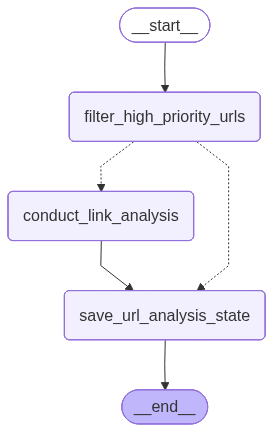

In [44]:
display(Image(link_analysis_graph.get_graph().draw_mermaid_png()))

In [45]:
priority_urls = [
    PrioritizedURL(
        url="https://www.qrcode-monkey.com/",
        reason="Example URL for testing",
        priority=1,
        page_number=0
    ),
    PrioritizedURL(
        url="https://docs.langchain.com/oss/python/langgraph/graph-api#command",
        reason="Test URL for testing",
        priority=2,
        page_number=1
    )
]

In [46]:
visual_analysis_input = {
    "visual_analysis_report": {
        "all_priority_urls": priority_urls
    },
    "output_directory": "output"
}

In [47]:
final_state = await link_analysis_graph.ainvoke(visual_analysis_input)

2025-10-22 08:53:51.826 | INFO     | __main__:filter_high_priority_urls:5 - 🔎 Filtering high priority URLs from visual analysis
2025-10-22 08:53:51.828 | DEBUG    | __main__:filter_high_priority_urls:14 - Found visual analysis report in state
2025-10-22 08:53:51.828 | DEBUG    | __main__:filter_high_priority_urls:19 - Found 2 URLs in dictionary format report
2025-10-22 08:53:51.829 | DEBUG    | __main__:filter_high_priority_urls:33 - Selected high priority URL: https://www.qrcode-monkey.com/ (priority: 1)
2025-10-22 08:53:51.830 | DEBUG    | __main__:filter_high_priority_urls:33 - Selected high priority URL: https://docs.langchain.com/oss/python/langgraph/graph-api#command (priority: 2)
2025-10-22 08:53:51.832 | INFO     | __main__:filter_high_priority_urls:38 - 🔎 Filtered URLs: 2 high priority (≤5), 0 low priority (>5)
2025-10-22 08:53:51.834 | INFO     | __main__:route_url_analysis:9 - 🚀 Dispatching 2 URL investigations in parallel
2025-10-22 08:53:51.835 | DEBUG    | __main__:route_